Задание к лабораторной работе №2:

1. Возьмите изображения из папки на диске https://drive.google.com/drive/folders/1mFrO0asFEPGhJWjUOj3D0XHsmSHKSKZL?usp=sharing
и файл с метками классов соответствующие 7 эмоциям https://docs.google.com/spreadsheets/d/1vWpbbfvTIkU00Sh8c2IDuOGUeyhIKSmU/edit?usp=sharing&ouid=100388187111922528695&rtpof=true&sd=true

2. Загрузите необходимые модули и ознакомьтесь с данными (допишите код, где это необходимо)
3. Выполните предобработку данных (допишите код, где это необходимо)
4. Напишите необходимый код для применнеия фильтров Габора с заданными параметрами к изображениям, сормируйте вектор признаков для каждого изображения
5. Напишите код для применения методов снижения размерности данных (покажите, что просходит на каждом шаге)
6. Используйте любой классификатор для решения задачи класификации
7. Приведите исследование зависимости точности классификации в зависимости от параметров фильтров Габора (варируйте 2 параметра по отдльности, например)
8. Приведите исследование зависимости точности классификации в зависимости от количества главных компонент
9. Сформируйте выводы



## **Загрузка данных и необходимых модулей**

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import PIL.Image
import collections
# import pylab as pl
import face_recognition as fr
import graphviz

from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from  matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Получает список изображений в папке
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)             
    return allFiles   

In [3]:
image_folder = r'F:\projects\vs_code\emoji_classification\all'
img_files_list = getListOfFiles(image_folder)
img_files_list

['F:\\projects\\vs_code\\emoji_classification\\all\\S005_001_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S005_001_00000011.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_001_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_002_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_002_00000014.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_003_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_004_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_004_00000019.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_005_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_006_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S010_006_00000015.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S011_001_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\all\\S011_001_00000016.png',
 'F:\\projec

In [4]:
#прочитаем файл с метками классов
# dic = {
#     0:'neutral',
#     1:'anger',
#     2:'contempt',
#     3:'disgust',
#     4:'fear',
#     5:'happiness',
#     6:'surprise',
# }
df = pd.read_csv('F://projects//vs_code//emoji_classification//label_dataset.csv') 
df = df.drop(columns=['Unnamed: 0'], axis=1)
# for i in range(7):
#     df.loc[df.label == i, 'label'] = dic[i]
df

,label,file name
0,1,S010_004_00000019.png
1,1,S011_004_00000021.png
2,1,S014_003_00000030.png
3,1,S022_005_00000032.png
4,1,S026_003_00000015.png
...,...,...
915,6,S133_009_00000006.png
916,6,S135_001_00000039.png
917,6,S136_001_00000019.png
918,6,S137_001_00000014.png


In [5]:
label_list = []
name_list = []
for i in range(len(img_files_list)):
    pic_name = img_files_list[i].split('\\')[-1]                          
    idx = df[df['file name'] == pic_name].index
    label_list.append(df.at[idx[0], 'label'])
    name_list.append(pic_name)
dic = {'name':name_list,'label':label_list}
df_target = pd.DataFrame(dic)
df_target.to_csv() 
df_target

,name,label
0,S005_001_00000001.png,0
1,S005_001_00000011.png,3
2,S010_001_00000001.png,0
3,S010_002_00000001.png,0
4,S010_002_00000014.png,6
...,...,...
915,S895_002_00000007.png,2
916,S999_001_00000001.png,0
917,S999_001_00000018.png,1
918,S999_003_00000001.png,0


In [6]:
def find_picture(name_pic):
    for val in img_files_list:
        if name_pic == val.split('\\')[-1]:
            return val

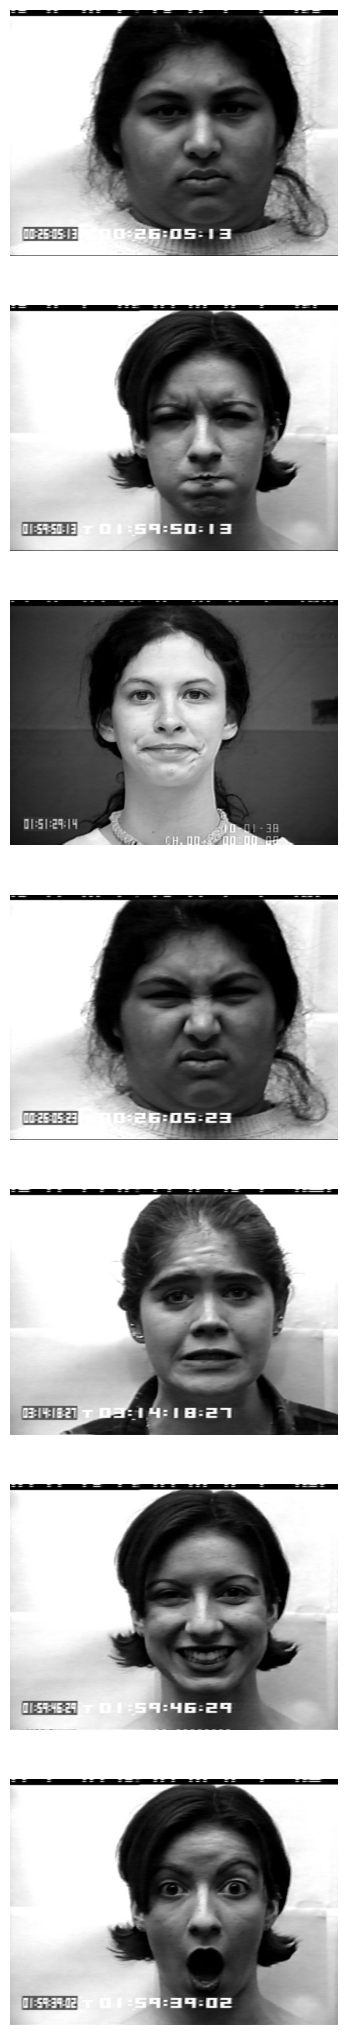

In [7]:
# вывести по одному изображению для каждого класса
res_gr = df.groupby('label')['file name'].apply(list)
plt.figure(figsize=(30,30))
for i in range(res_gr.shape[0]):
    path = find_picture(res_gr[i][0])
    image = cv2.imread(path)
    plt.subplot(res_gr.shape[0]+ 1, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')
    

## Предобработка изображений

In [8]:
def ImagePreProcessing(data, sigma_GF, IMG_HEIGHT, IMG_WIDTH):
    X = []
    for image in data: 
        image = cv2.imread(image)

        image_GF = cv2.GaussianBlur(image, (5, 5), sigma_GF)    # Gaussian filter

        face_loc = fr.face_locations(img = image_GF, model='hog')   # Face detection and crop
        if len(face_loc) > 1:
          face_loc=[(face_loc[0])]
        top, right, bottom, left = face_loc[0]
        image_CROPPED = image_GF[top:bottom, left:right]

        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))   # Histogram equalization
        lab = cv2.cvtColor(image_CROPPED, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l2 = clahe.apply(l)
        lab = cv2.merge((l2,a,b))
        img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)

        image_SCALED = cv2.resize(img_clahe, (IMG_HEIGHT, IMG_WIDTH))
        X.append(image_SCALED)

    X = np.array(X)
    return X

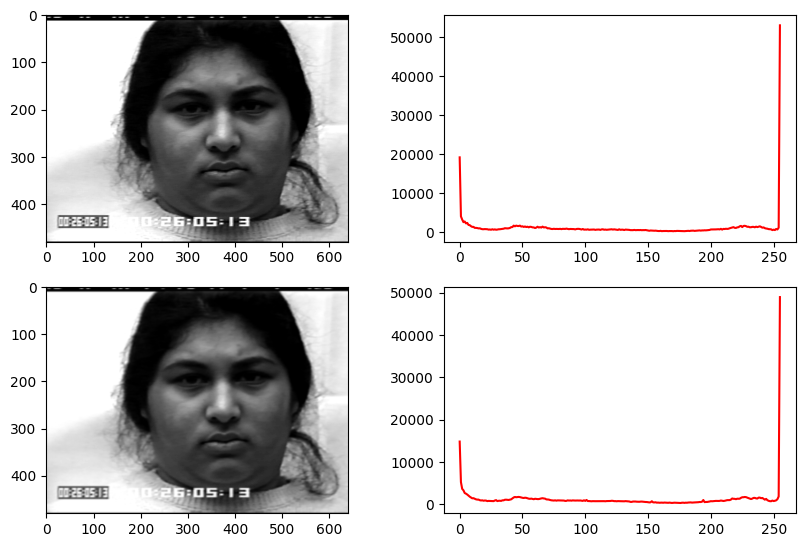

In [9]:
#визуализировать применение фильтра Гаусса к одному изображению (до/после)
image = cv2.imread(img_files_list[0])
#         image_Gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY);
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sigma_GF = 1
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')

hist1 = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.subplot(3, 2, 2)
plt.plot(hist1, color='red')

image_GF = cv2.GaussianBlur(image, (5, 5), 1)
plt.subplot(3, 2, 3)
plt.imshow(image_GF, cmap='gray')

hist2 = cv2.calcHist([image_GF], [0], None, [256], [0, 256])
plt.subplot(3, 2, 4)
plt.plot(hist2, color='red')


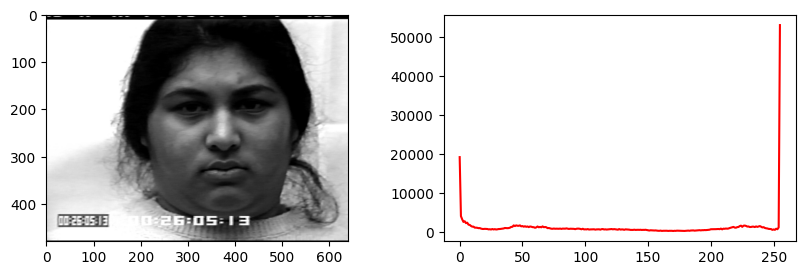

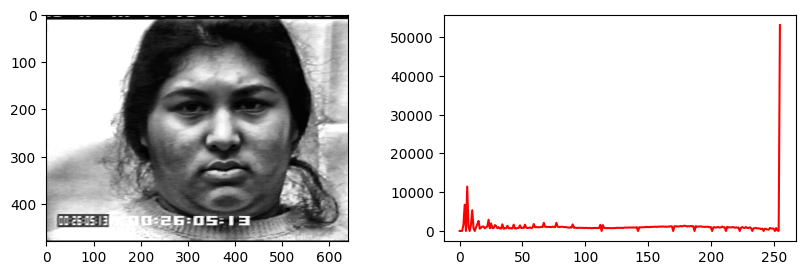

In [10]:
#визуализировать применение эквализации гистограммы к одному изображению (до/после)
img = cv2.imread(img_files_list[0])

# image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sigma_GF = 1
img = cv2.circle(img, (205, 526), radius=1, color=(0, 0, 255), thickness=10)
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(img)

hist1 = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.subplot(3, 2, 2)
plt.plot(hist1, color='red')

clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
l2 = clahe.apply(l)
lab = cv2.merge((l2,a,b))
img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 3)
plt.imshow(img_clahe, cmap='gray')

hist2 = cv2.calcHist([img_clahe], [0], None, [256], [0, 256])
plt.subplot(3, 2, 4)
plt.plot(hist2, color='red')

In [11]:
#применение функции для преобработки данных
X_processed = ImagePreProcessing(img_files_list, 1, 64, 64)

## **Извлечение признаков с фильтрами Габбора**


In [12]:
# напишите функцию (GaborFiltersFeatures) для создания 9 фильтров Габора (cv2.getGaborKernel) со следующими параметрами

theta_range = np.arange(0, np.pi, np.pi/8) # Ориентация полосочек
lamda = 4* np.pi/4 # Длина волны синуса
gamma = 0.5 # Пространственное соотношение сторон.
sigma = 1 # Стандартное отклонение гаусса
ksize = 9 # Размер фильтра
phi = 0 # ФАза

def GaborFiltersFeatures(ksize, sigma, theta_range, lamda, gamma, phi):
    # Создаем фильтер
    filters = []
    for theta in theta_range:
            kern = cv2.getGaborKernel(
                (ksize, ksize), sigma, theta, lamda,
                gamma, phi, ktype=cv2.CV_64F
            )
            kern /= 1.0 * kern.sum()
            filters.append(kern)
    return filters

def apply_filter(x_processed, filters):
    res = []
    depth = -1
    for i, img in enumerate(x_processed):
        newimage = np.zeros_like(img)
        flat_ar = []
        for kern in filters:
            image_filter = cv2.filter2D(img, depth, kern)
            np.maximum(newimage, image_filter, newimage)
            flat_ar.append(np.array(newimage))
        flat_ar.append(np.array(img))
        res.append(np.array(flat_ar).flatten())
        
    res = np.array(res)

    return res

In [13]:
filters = GaborFiltersFeatures(ksize, sigma, theta_range, lamda, gamma, phi)
len(filters)

8

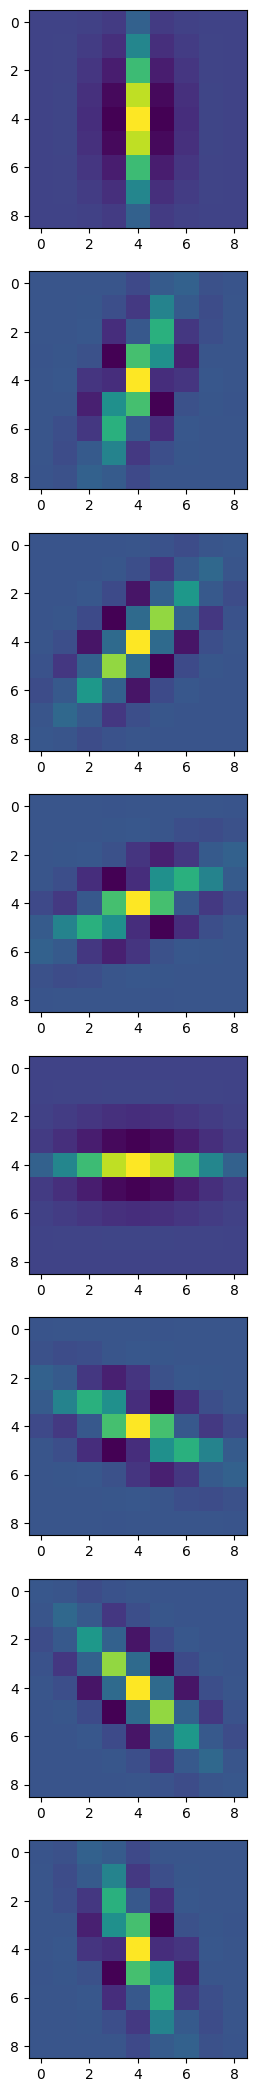

In [14]:
# напишите код для визуализации фильтров Габора с
plt.figure(figsize=(30, 30))
for i, filt in enumerate(filters):
    plt.subplot(len(filt), 1, i + 1)
    plt.imshow(filt)

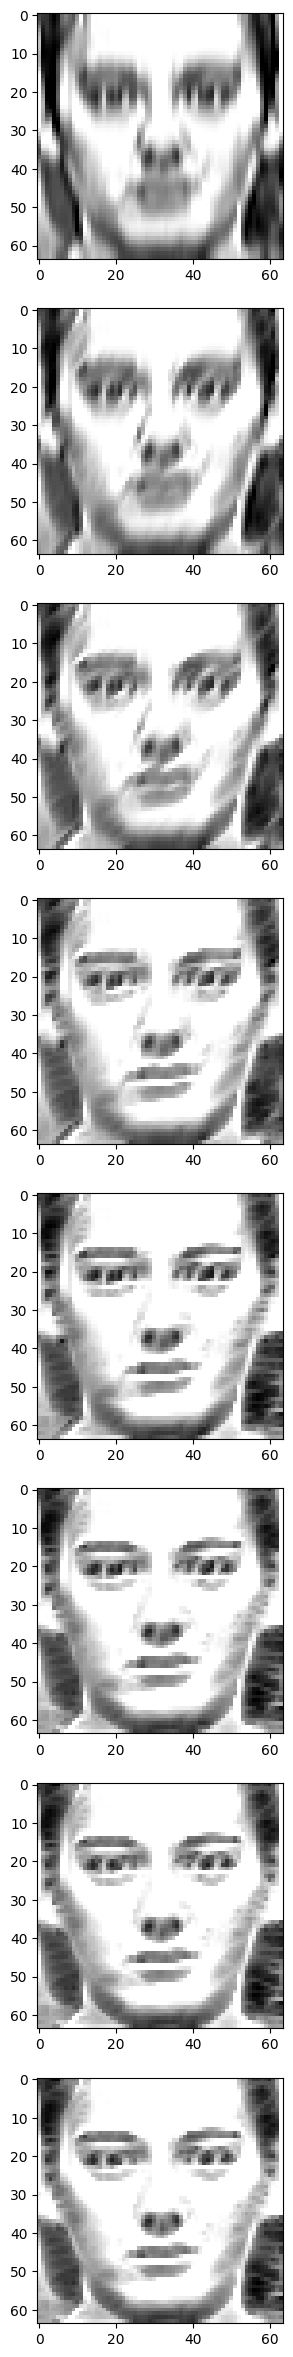

In [15]:
# примените фильтры Габора к любому изображению из датасета, выведите, что получилось
plt.figure(figsize=(30, 30))
image_g = []
depth = -1
img = X_processed[77]
newimage = np.zeros_like(img)
for kern in filters:
    image_filter = cv2.filter2D(img, depth, kern)
    np.maximum(newimage, image_filter, newimage)
    image_g.append(np.array(newimage))

image_g = np.array(image_g)
for i, img in enumerate(image_g):
    plt.subplot(image_g.shape[0], 1, i + 1)
    plt.imshow(img, cmap='gray')

## **Применение снижения размерности**
* PCA and LDA

In [16]:
X_featured = apply_filter(X_processed, filters)
X_featured.shape

(920, 36864)

In [17]:
scaler = StandardScaler()
scaler.fit(X_featured)
X_scaled = scaler.transform(X_featured)
X_scaled[0], X_scaled.shape

(array([-0.12856205, -0.35794953, -0.70237566, ..., -0.42260495,
         0.24258111,  0.35458878]),
 (920, 36864))

In [18]:
pca = PCA(0.9)
pca.fit(X_scaled)
ratio = pca.explained_variance_ratio_

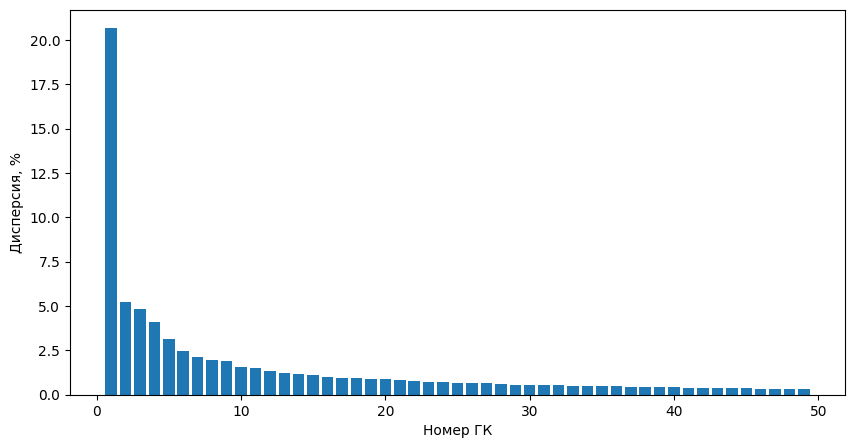

In [19]:
# Оценим вклад ГК
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер ГК")
plt.ylabel("Дисперсия, %")
plt.bar(range(1, 50),ratio[:49] *100)
plt.show()

In [20]:
summ = 0
i = 0
while summ < 90:
    summ += ratio[i] * 100
    i +=1
num_mc = i - 1
summ, num_mc

(90.04818527477514, 166)

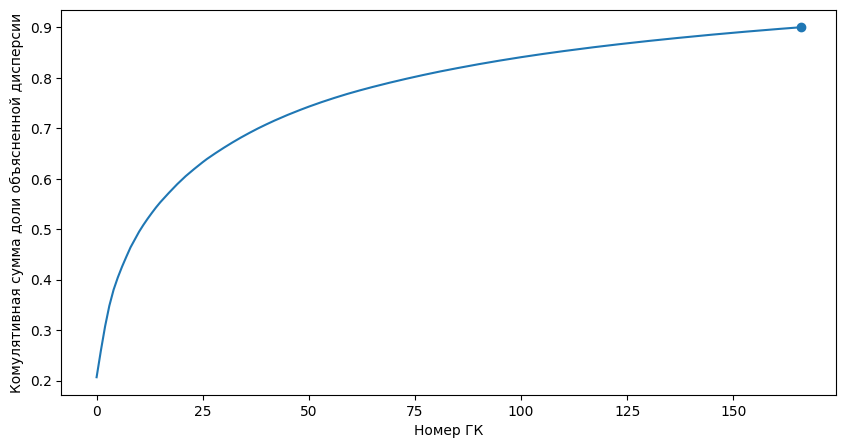

In [21]:
cum_sum = np.cumsum(ratio)
fig = plt.figure(figsize = (10, 5)) 
plt.xlabel("Номер ГК") 
plt.ylabel("Комулятивная сумма доли объясненной дисперсии") 
plt.plot(cum_sum[:]) 
plt.scatter(num_mc, cum_sum[num_mc]) 
plt.show()

pca = PCA(n_components=num_mc)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)
x_pca.shape

# Лабораторная работа №4

1. Сформировать 3 вида векторов признаков:
* Исходные данные + PCA
* Исходные данные + PCA + LDA
* Исходные данные + LDA

2. Применить все изученные классификаторы для каждого вектора признаков:

* Decidion Tree
* Random Forest
* AdaBoost
* GradientBoost
* k-NN
* SVM
* NB

Для настройки параметров использвоать GridSearch (в целях экономии времени можно выбрать для настройки по 1-2 параметра)

3. Для 3 типов векторов для каждого классификатора рассчитать метрики: 
* Presiсion для многоклассовой классификации с момощью макроусреднения (см. Семинар №7)
* Recall
* F1
* Accuracy

4. Сделать выводы о проделанной работе и полученных результатах

Обучение проводить с делением выборки на тест, трейн и валидацию (если будет мало данных можно без валидации) или в режиме кросс-валидации (на выбор)

По желанию можно использовать методы баллансировки классов из imblearn

По желанию (для достижения наилучшей точности классификации) можно менять любые параметры для формирования векторов признаков и обработки изображений и т.п.






Решение задачи бинарной классификации с применением МГК, ЛДА и Decidion Tree, Random Forest, AdaBoost

Сформируем бинарные тестовую и тренировочную выборки:

In [25]:
# dic_label = {
#     'neutral': 0,
#     'anger': 1,
#     'contempt': 2,
#     'disgust': 3,
#     'fear': 4,
#     'happiness': 5,
#     'surprise': 6,
# }
# for i, val in enumerate(df_target.label):
#     df_target.label.iloc[i] = dic_label[val]

In [28]:
    y = np.array(df_target.label)
    X_train, X_test, y_train, y_test = train_test_split(X_featured, y,
                                                        test_size=0.2)

    labeled_df = pd.DataFrame(data=X_train)
    labeled_df['label'] = y_train
    resampled = pd.DataFrame(np.repeat(
        labeled_df[labeled_df.label != 0].values, 3, axis=0))

resampled

,0,1,2,3,4,5,6,7,8,9,...,36855,36856,36857,36858,36859,36860,36861,36862,36863,36864
0,63,54,49,31,29,58,95,116,96,87,...,249,252,196,153,131,157,164,171,162,3
1,63,54,49,31,29,58,95,116,96,87,...,249,252,196,153,131,157,164,171,162,3
2,63,54,49,31,29,58,95,116,96,87,...,249,252,196,153,131,157,164,171,162,3
3,31,17,20,36,32,38,38,52,58,48,...,128,169,190,180,126,41,8,83,158,5
4,31,17,20,36,32,38,38,52,58,48,...,128,169,190,180,126,41,8,83,158,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,84,50,34,37,19,48,72,74,9,71,...,31,107,110,119,107,53,70,83,113,2
713,84,50,34,37,19,48,72,74,9,71,...,31,107,110,119,107,53,70,83,113,2
714,192,179,61,0,10,8,0,12,39,101,...,158,226,241,86,180,174,187,227,78,6
715,192,179,61,0,10,8,0,12,39,101,...,158,226,241,86,180,174,187,227,78,6


In [41]:
resampled.columns = labeled_df.columns
resampled_df = pd.concat([labeled_df[labeled_df.label == 0], resampled], ignore_index=True)
resampled_df

,0,1,2,3,4,5,6,7,8,9,...,36855,36856,36857,36858,36859,36860,36861,36862,36863,label
0,0,18,76,172,177,140,178,208,207,208,...,48,55,56,55,50,50,51,57,58,0
1,11,5,6,6,6,6,6,6,6,6,...,152,132,114,69,153,130,181,204,239,0
2,52,52,23,21,28,45,39,59,81,87,...,153,85,24,40,52,80,145,184,195,0
3,55,46,32,31,19,40,69,89,76,75,...,50,24,9,4,4,4,10,27,64,0
4,11,8,0,0,0,38,75,116,119,105,...,89,76,71,74,81,93,105,107,96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,84,50,34,37,19,48,72,74,9,71,...,31,107,110,119,107,53,70,83,113,2
1210,84,50,34,37,19,48,72,74,9,71,...,31,107,110,119,107,53,70,83,113,2
1211,192,179,61,0,10,8,0,12,39,101,...,158,226,241,86,180,174,187,227,78,6
1212,192,179,61,0,10,8,0,12,39,101,...,158,226,241,86,180,174,187,227,78,6


In [42]:
drop_indices = np.random.choice(resampled_df[resampled_df.label == 0].index, int(len(resampled_df[resampled_df.label == 0])/2), replace=False)

In [44]:
resampled_df.label.value_counts()

0    497
6    201
5    165
3    141
1    114
4     60
2     36
Name: label, dtype: int64

In [45]:
resampled_df = resampled_df.drop(drop_indices)

In [46]:
resampled_df.label.value_counts()

0    249
6    201
5    165
3    141
1    114
4     60
2     36
Name: label, dtype: int64

In [ ]:
print(labeled_df.label.value_counts())

resampled.columns = labeled_df.columns

resampled_df = pd.concat([labeled_df[labeled_df.label == 0], resampled], ignore_index=True)


print(resampled_df.label.value_counts())
drop_indices = np.random.choice(resampled_df[resampled_df.label == 0].index, int(len(resampled_df[resampled_df.label == 0])/2), replace=False)
resampled_df = resampled_df.drop(drop_indices)
print(drop_indices.shape)
print(resampled_df.label.value_counts())

In [26]:
labeled_df = pd.DataFrame(data=X_featured)
labeled_df['label'] = df_target.label
labeled_df['file name'] = df_target.name
labeled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,36856,36857,36858,36859,36860,36861,36862,36863,label,file name
0,39,25,12,12,7,9,12,10,1,11,...,50,26,23,30,48,78,123,129,0,S005_001_00000001.png
1,41,17,12,16,13,8,13,11,0,10,...,52,30,29,31,43,68,116,125,3,S005_001_00000011.png
2,69,30,9,9,21,13,24,78,65,25,...,78,78,85,93,112,159,190,192,0,S010_001_00000001.png
3,74,26,11,16,20,15,25,95,72,11,...,86,85,88,107,132,171,179,179,0,S010_002_00000001.png
4,60,48,4,17,24,13,8,49,90,46,...,61,79,94,107,130,172,191,196,6,S010_002_00000014.png


Выведем разметку X_featured

In [70]:
# upsampled= pd.DataFrame(np.repeat(labeled_df[labeled_df.label != 'neutral'].values, 3, axis=0))
# upsampled.columns = labeled_df.columns
# upsampled_df = pd.concat([labeled_df[labeled_df.label == 'neutral'], upsampled])
# upsampled_df.label.value_counts()
# upsampled_df = upsampled_df.reset_index(drop=True)


In [71]:
# dic_label = {
#     'neutral': 0,
#     'anger': 1,
#     'contempt': 2,
#     'disgust': 3,
#     'fear': 4,
#     'happiness': 5,
#     'surprise': 6,
# }

# for i, val in enumerate(upsampled_df.label):
#     upsampled_df.label.iloc[i] = dic_label[val]

In [72]:
y = np.array(labeled_df.label)
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([621,  45,  18,  59,  25,  69,  83], dtype=int64))

Очень много нейтральной эмоции

In [73]:
X_featured

array([[ 73,  24,   0, ...,  78, 123, 129],
       [104,   0,   7, ...,  68, 116, 125],
       [167,   0,   0, ..., 159, 190, 192],
       ...,
       [255,   0, 221, ...,  82,  90,  73],
       [255,   0, 202, ...,  38,  53, 126],
       [ 12, 255,   0, ...,  76, 127, 173]], dtype=uint8)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X_featured, y, test_size=0.2)

In [75]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 501]
 [  1  33]
 [  2  15]
 [  3  53]
 [  4  19]
 [  5  52]
 [  6  63]]


In [76]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 120]
 [  1  12]
 [  2   3]
 [  3   6]
 [  4   6]
 [  5  17]
 [  6  20]]


In [24]:
labeled_df = pd.DataFrame(data=X_train)
labeled_df['label'] = y_train
labeled_df

NameError: name 'X_train' is not defined

In [22]:
labeled_df.label.value_counts()

NameError: name 'labeled_df' is not defined

In [23]:
upsampled= pd.DataFrame(np.repeat(labeled_df[labeled_df.label != 0].values, 6, axis=0))
upsampled.columns = labeled_df.columns
upsampled_df = pd.concat([labeled_df[labeled_df.label == 0], upsampled])
upsampled_df.label.value_counts()
upsampled_df = upsampled_df.reset_index(drop=True)
upsampled_df

NameError: name 'labeled_df' is not defined

In [80]:
upsampled_df.label.value_counts()

0    501
6    378
3    318
5    312
1    198
4    114
2     90
Name: label, dtype: int64

In [81]:
y_train = upsampled_df.label
X_train = upsampled_df.drop('label', axis=1)

In [82]:
X_train.shape

(1911, 36864)

### 1. Сформирвоать 3 типа входных данных
* Применить к вектору признаков PCA (из ЛР№1)

In [83]:
# Временно сохраним старые данные в новые переменные 
X_test_no_PCA = X_test.copy()
X_train_no_PCA = X_train.copy()

In [84]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled.shape

(1911, 36864)

In [85]:
pca = PCA(0.95)
pca.fit(X_train_scaled)
ratio = pca.explained_variance_ratio_
x_train_pca = pca.transform(X_train_scaled)
pca.components_.shape

(341, 36864)

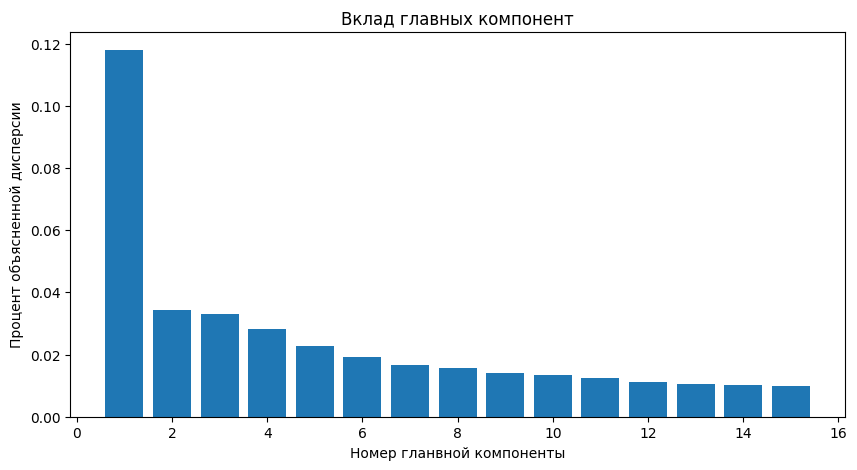

In [86]:
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер гланвной компоненты")
plt.ylabel("Процент объясненной дисперсии")
plt.title("Вклад главных компонент")
plt.bar(range(1, 16),ratio[:15])
plt.show()

In [87]:
# Итоговые данные 
data_pca = pd.DataFrame(data=x_train_pca)
X_train = data_pca
X_train.shape

(1911, 341)

In [88]:
# Шаг 1 - Стандартизация X_test
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled.shape

(184, 36864)

In [89]:
# Стандартизованные данные
pd.DataFrame(data=X_test_scaled)

,0,1,2,3,4,5,6,7,8,9,...,36854,36855,36856,36857,36858,36859,36860,36861,36862,36863
0,-0.707709,1.091465,1.096530,1.472012,0.548868,1.029424,1.054453,1.290406,-0.138020,-0.228816,...,-0.320591,-0.224147,-0.001632,-0.022920,0.197528,0.481146,0.685256,0.822199,0.893541,-0.796731
1,-0.707709,-0.070438,-0.075140,0.833627,0.860857,1.336972,1.020271,-0.540305,0.152289,0.814820,...,-0.784044,-0.845406,-0.706821,-0.808967,-0.221692,0.277627,0.435441,0.467504,0.497266,-0.143670
2,-0.707709,-0.226157,-0.432807,2.210534,1.796821,-0.579288,1.043059,1.096424,0.871750,0.682714,...,-1.204048,-1.028960,-0.954943,-0.846398,-0.793356,-0.821377,-0.758118,-0.866150,-0.875542,-0.728704
3,-0.707709,-0.741228,0.615529,-0.192794,0.236880,0.568102,0.769600,-0.225083,0.543575,0.524187,...,-1.233013,-1.113677,-1.333655,-1.407861,-1.403130,-1.336959,-1.202234,-1.362723,-1.413344,-1.300132
4,-0.707709,-0.741228,0.134528,1.509564,1.912373,0.296040,0.837964,0.514476,0.366865,-0.215605,...,-0.581283,0.665382,0.964737,-0.185120,-1.161761,-1.214847,-1.021812,-0.922901,-0.734016,-0.320541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.626293,-0.717271,-0.827475,-0.856213,0.213770,-0.910493,-1.338316,-0.552429,-0.958459,-1.404557,...,-1.392325,-1.085438,-0.824352,-0.846398,-0.945799,-1.024896,-1.118962,-0.951277,-0.762321,-0.388568
180,1.653343,0.744092,2.317534,-0.856213,-1.034183,1.904752,-0.780003,-0.697916,-1.425478,0.828030,...,1.938740,1.950258,1.748280,1.686422,1.671149,0.359034,-0.300125,-0.383765,-0.408504,-0.320541
181,-0.707709,2.217433,0.418195,1.083974,1.912373,1.632691,0.815176,1.120672,0.606686,0.378871,...,-1.609569,-0.788928,-0.027750,0.600928,0.947042,1.363062,1.184885,1.375523,0.836930,-0.184487
182,-0.603032,-0.741228,-0.617808,-0.856213,-1.034183,0.603588,1.168394,0.284121,0.758151,0.339239,...,0.867006,0.439470,-0.458699,-0.472090,-0.412247,-0.387203,-0.300125,-0.383765,-0.592489,-0.606255


In [90]:
# pca = PCA(n_components=X_train.shape[1])
# pca = PCA(0.95)
# pca.fit(X_test_scaled)
x_test_pca = pca.transform(X_test_scaled)

In [91]:
x_test_pca.shape

(184, 341)

In [92]:
# Итоговые данные 
data_pca = pd.DataFrame(data=x_test_pca)
X_test = data_pca
X_test

,0,1,2,3,4,5,6,7,8,9,...,331,332,333,334,335,336,337,338,339,340
0,6.921754,7.528567,51.590715,6.545328,-4.990788,15.922555,-13.857736,-19.814033,-8.264044,-5.651165,...,-4.171492,-1.128627,-4.383100,-0.339964,-1.468225,2.544439,-1.876549,-0.432017,1.389605,1.690269
1,-51.762048,33.499957,-11.368848,-16.589127,12.750357,31.414120,37.434586,3.641715,3.934853,-8.567514,...,4.651017,-1.380983,5.569546,-3.182031,-1.988672,-5.075943,0.376424,1.136558,4.429293,-3.267391
2,7.917688,21.931428,71.281525,-9.522021,-22.060429,2.042240,1.327926,-9.005202,-7.365604,11.065959,...,0.218586,-2.444340,7.670055,-3.956932,3.116463,3.596882,4.160025,0.260539,3.852285,-2.724713
3,-67.016518,-18.116554,24.838724,50.193359,-30.569859,-22.351848,-12.245235,-6.711803,-39.831901,-4.686343,...,-1.705554,5.055816,-0.640802,-4.226196,-0.079303,-5.070139,-4.218752,-0.367713,0.791577,3.539416
4,-5.504983,25.294986,39.591900,-1.678269,-8.098790,-0.805717,27.699960,31.477287,-37.372453,26.983769,...,2.436806,-10.655783,3.162536,4.641510,-1.877933,-1.992146,-1.719769,-8.454866,7.785208,-2.496707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,63.943463,-33.876622,-3.561933,54.667117,-5.854659,14.004841,16.667506,-10.658662,-3.962276,-40.046319,...,-4.594923,0.220584,0.929740,-2.660494,4.554170,-7.806375,-2.454349,1.304645,-1.559831,-4.482668
180,-92.445349,-6.385949,-31.437465,-13.474586,28.336921,-49.171618,8.355994,7.911985,-3.184969,30.594370,...,-2.521622,2.807015,1.013878,-2.955784,-3.881218,-2.911783,0.765701,5.421470,0.094020,1.120235
181,6.941732,-51.689332,37.628437,-14.019722,-1.121124,18.081769,-10.134768,0.668201,21.755605,-8.282266,...,3.100084,-0.967785,-9.526307,7.207392,0.246654,-1.942909,5.608061,4.892127,5.529391,0.469541
182,58.932361,-31.465009,49.936206,-13.274272,-33.719801,-21.354169,-16.301114,-42.100584,25.647433,-0.003098,...,-1.961872,-1.862310,-8.097114,0.803928,-2.576797,2.938265,-0.141550,1.085582,1.422591,1.546502


In [93]:
X_train.shape

(1911, 341)

In [94]:
X_test.shape

(184, 341)

PCA

In [95]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
1906    5
1907    5
1908    5
1909    5
1910    5
Name: label, Length: 1911, dtype: int64

Точность модели на обучающей выборке:  0.99
Точность модели на тестовой выборке:  0.83
Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":



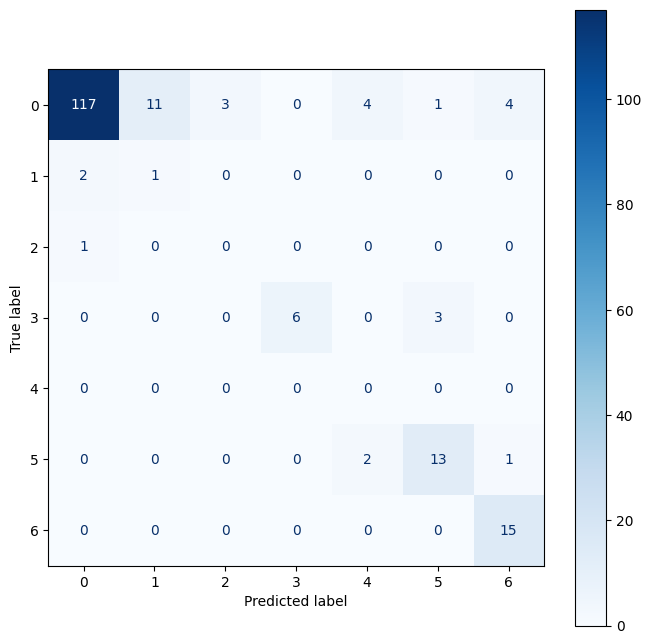

In [96]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
LDA_prediction = LDA_model.predict(X_test)

LDA_train_accuracy = LDA_model.score(X_train, y_train)
LDA_test_accuracy = LDA_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (LDA_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LDA_test_accuracy, 2))

print('Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":\n')

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(LDA_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [107]:
confusion_matrix(LDA_prediction, y_test)

array([[117,  11,   3,   0,   4,   1,   4],
       [  2,   1,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   6,   0,   3,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,  13,   1],
       [  0,   0,   0,   0,   0,   0,  15]], dtype=int64)

In [113]:
report = classification_report(y_test, LDA_model.predict(X_test), output_dict=True)
df = pd.DataFrame(report).transpose()
df

f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.835714,0.975000,0.900000,120.000000
1,0.333333,0.083333,0.133333,12.000000
2,0.000000,0.000000,0.000000,3.000000
3,0.666667,1.000000,0.800000,6.000000
4,0.000000,0.000000,0.000000,6.000000
5,0.812500,0.764706,0.787879,17.000000
6,1.000000,0.750000,0.857143,20.000000
accuracy,0.826087,0.826087,0.826087,0.826087
macro avg,0.521173,0.510434,0.496908,184.000000
weighted avg,0.772273,0.826087,0.787700,184.000000


In [112]:
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.835714,0.975000,0.900000,120.000000
1,0.333333,0.083333,0.133333,12.000000
2,0.000000,0.000000,0.000000,3.000000
3,0.666667,1.000000,0.800000,6.000000
4,0.000000,0.000000,0.000000,6.000000
5,0.812500,0.764706,0.787879,17.000000
6,1.000000,0.750000,0.857143,20.000000
accuracy,0.826087,0.826087,0.826087,0.826087
macro avg,0.521173,0.510434,0.496908,184.000000
weighted avg,0.772273,0.826087,0.787700,184.000000


In [105]:
print ( classification_report(y_test, LDA_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       120
           1       0.33      0.08      0.13        12
           2       0.00      0.00      0.00         3
           3       0.67      1.00      0.80         6
           4       0.00      0.00      0.00         6
           5       0.81      0.76      0.79        17
           6       1.00      0.75      0.86        20

    accuracy                           0.83       184
   macro avg       0.52      0.51      0.50       184
weighted avg       0.77      0.83      0.79       184



f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2. Tree

In [ ]:
clf = tree.DecisionTreeClassifier()
#Подбор лучших параметров:
par = {'max_depth':range(6, 13), 'min_samples_split':range(2, 6),
     'min_samples_leaf':range(2, 6)}
search = GridSearchCV(clf, par, cv=5)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3}

In [ ]:
best_tree=search.best_estimator_
clf_best=best_tree
dot_data = tree.export_graphviz(best_tree, out_file=None,  
                                class_names=[
                                    'Neutral','Anger', 'contempt', 'Disgust',
                                    'Fear', 'Happiness', 'Surprise'],
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
# graph.render("best_tree", view=True)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
train_accuracy = clf_best.score(X_train, y_train)
test_accuracy = clf_best.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy, 2))

Точность модели на обучающей выборке:  0.81
Точность модели на тестовой выборке:  0.52


In [ ]:
print (classification_report(y_test, clf_best.predict(X_test)))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
    contempt       0.00      0.00      0.00         4
     disgust       0.00      0.00      0.00        15
        fear       0.33      0.20      0.25         5
   happiness       0.10      0.06      0.08        16
     neutral       0.66      0.80      0.72       118
    surprise       0.00      0.00      0.00        15

    accuracy                           0.52       184
   macro avg       0.16      0.15      0.15       184
weighted avg       0.44      0.52      0.48       184



/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
clf = RandomForestClassifier(random_state=17)
par = {'n_estimators': range(13, 20), 'max_depth' : range(3, 10), 
     'min_samples_split' : range(2, 7),
     'min_samples_leaf': range(1,5)}
search = GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 18}

In [ ]:
clf_best_rf = search.best_estimator_
clf_best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_split=3, n_estimators=18,
                       random_state=17)

In [ ]:
train_accuracy_rf = clf_best_rf.score(X_train, y_train)
test_accuracy_rf = clf_best_rf.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy_rf, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy_rf, 2))

Точность модели на обучающей выборке:  0.84
Точность модели на тестовой выборке:  0.62


In [ ]:
print ('\n clasification report:\n', classification_report(y_test, clf_best_rf.predict(X_test)))


 clasification report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
    contempt       0.00      0.00      0.00         4
     disgust       0.00      0.00      0.00        15
        fear       0.00      0.00      0.00         5
   happiness       0.00      0.00      0.00        16
     neutral       0.64      0.97      0.77       118
    surprise       0.00      0.00      0.00        15

    accuracy                           0.62       184
   macro avg       0.09      0.14      0.11       184
weighted avg       0.41      0.62      0.49       184



/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ada boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20, min_samples_leaf=5), 
                         algorithm="SAMME",n_estimators=100, learning_rate=0.8)
bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20),
                   learning_rate=0.8, n_estimators=100)

In [ ]:
print (classification_report(y_test, bdt.predict(X_test)))

              precision    recall  f1-score   support

       anger       0.33      0.09      0.14        11
    contempt       0.00      0.00      0.00         4
     disgust       0.50      0.07      0.12        15
        fear       0.00      0.00      0.00         5
   happiness       0.00      0.00      0.00        16
     neutral       0.65      0.94      0.77       118
    surprise       0.00      0.00      0.00        15

    accuracy                           0.61       184
   macro avg       0.21      0.16      0.15       184
weighted avg       0.48      0.61      0.51       184



/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/Anton2008/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Матрица несоответствий метода "AdaBoost":



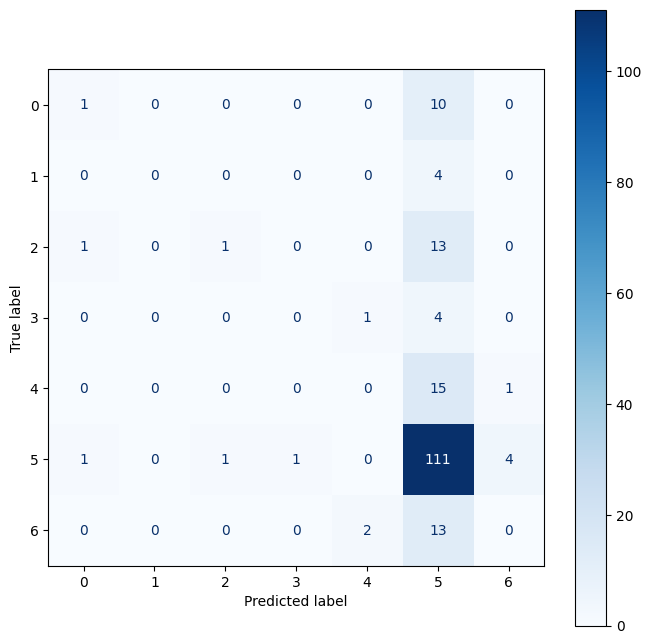

In [ ]:
print('Матрица несоответствий метода "AdaBoost":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, bdt.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

### Метод градиентного бустинга

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# define the model with default hyperparameters
model = GradientBoostingClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [30, 50, 100]
grid['learning_rate'] = [0.1]
grid['max_depth'] = [2, 3, 4]
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=10, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

Кросс-валидация

In [ ]:
print('Матрица несоответствий метода "Градиентный бустинг":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_result.predict(X_test)))
disp.plot(cmap = 'Blues', ax=ax);

Сравним

In [ ]:
print ('\n clasification report:\n', classification_report(y_test, grid_result.predict(X_test)))

### KNN

In [ ]:
clf = KNeighborsClassifier()
par = {'n_neighbors': range(1, 15)}
search = GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors = 1)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)

KNN_train_accuracy = KNN_model.score(X_train, y_train)
KNN_test_accuracy = KNN_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (KNN_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (KNN_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "KNN":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(KNN_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [ ]:
print ('\n clasification report:\n', classification_report(y_test, KNN_prediction))

### Метод опорн векторов 

In [ ]:
clf = SVC()
par={'degree': range(1,15)}
search=GridSearchCV(clf, par, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

In [ ]:
SVC_model = SVC(gamma='scale', kernel='poly', degree=1) 
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test) 

SVC_train_accuracy = SVC_model.score(X_train, y_train)
SVC_test_accuracy = SVC_model.score(X_test, y_test)
print ('Точность модели на обучающей выборке: ', round (SVC_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (SVC_test_accuracy, 2))

fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода опорных векторов:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(SVC_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [ ]:
print ('\n clasification report:\n', classification_report(y_test, SVC_prediction))

Не сильно лучше

Бинарная классификация

1. Использовать вектор признаков из ЛР№1
Далее сформирвоать 3 типа входных данных:
* Применить к вектору признаков PCA (из ЛР№1)
* Применить к вектору признаков LDA
* Применить к вектору признаков PCA (из ЛР№1) и после LDA

2. Для каждого типа векторов признакив применить 3 алгоитма классификации и получить метрики классифкации для тестового набора и в режиме кросс-валидации:
* DT (визуализировать дерево)
* RF
* AdaBoost

3. Подобрать параметры всех алгоритмов с GridSearch, получить новые значения точности классификации

4. Построить графики зависимости точности класификации от изменения 1 паремтра каждого алгоритма

5. Написать функцию, которая принимает на вход следующие параметры:
- выбранный алгоритм
- параметры алгоритма
- количестово главных компонет МГК, которые будут использоваться для классификации
- будет ли применяться после МГК ЛДА - True или False
- будет ли проводиться расчет точности по тестовой выборке или в режиме кросс валидации

5a. Проварьировать параметр дерева и построить график зависимости точности от параметра дерева

5b. Вывести график зависимости точности классификации DT от количества главных компонент

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [ ]:
clf = RandomForestClassifier(random_state=17)
par = {'n_estimators': range(13, 20), 'max_depth' : range(3, 10), 
     'min_samples_split' : range(2, 7),
     'min_samples_leaf': range(1,5)}
clf_RF_GS = GridSearchCV(clf, par, cv=5, n_jobs=-1)
clf_RF_GS.fit(X_train, y_train)
clf_RF_GS.best_params_

In [ ]:
clf_best_rf = clf_RF_GS.best_estimator_
clf_best_rf.fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, best_tree.predict(X_test)))

* AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier(
    tree.DecisionTreeClassifier(
        random_state=17, max_depth=2, min_samples_split=20,
        min_samples_leaf=5
    )
)
par = { 'learning_rate': [x / 10.0 for x in range(7, 9, 1)] }
search = GridSearchCV(bdt, par, cv=4, n_jobs=-1)
search.fit(X_train, y_train)
print('search.best_params_')
bdt_best = search.best_estimator_
bdt_best.fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, best_tree.predict(X_test)))

Бинарная классификация

1. Использовать вектор признаков из ЛР№1
Далее сформирвоать 3 типа входных данных:
* Применить к вектору признаков PCA (из ЛР№1)
* Применить к вектору признаков LDA
* Применить к вектору признаков PCA (из ЛР№1) и после LDA

2. Для каждого типа векторов признакив применить 3 алгоитма классификации и получить метрики классифкации для тестового набора и в режиме кросс-валидации:
* DT (визуализировать дерево)
* RF
* AdaBoost

3. Подобрать параметры всех алгоритмов с GridSearch, получить новые значения точности классификации

4. Построить графики зависимости точности класификации от изменения 1 паремтра каждого алгоритма

5. Написать функцию, которая принимает на вход следующие параметры:
- выбранный алгоритм
- параметры алгоритма
- количестово главных компонет МГК, которые будут использоваться для классификации
- будет ли применяться после МГК ЛДА - True или False
- будет ли проводиться расчет точности по тестовой выборке или в режиме кросс валидации

5a. Проварьировать параметр дерева и построить график зависимости точности от параметра дерева

5b. Вывести график зависимости точности классификации DT от количества главных компонент



In [ ]:
def decision_tree(
        X, y, alg_params=tuple(),
        n_components=None, pca_lda=False, 
        ):
    classification_tree = best_tree.fit(X_train, y_train)

def random_forest(alg_params=tuple(), n_components=None, pca_lda=False):
    pass

def ada_boost(alg_params=tuple(), n_components=None, pca_lda=False):
    pass
    

def classification_func(X, y, alg_type=None, n_components=None,
                        pca_lda=False, cross_valid=False **kwargs):
    if alg_typle:
        raise Exception('Wrong function arguments')
        return 0
    if alg_type == 'DecisionTree':
        pass
    elif alg_type == 'Random forest':
        pass
    elif alg_type == 'AdaBoost':
        pass
    else:
        raise Exception('There is no such type of algorytm')
        return 0
    `